# **O Método de Monte Carlo – Algoritmo de Metropolis**
---

## **Dupla**
* Diane Fenzi Gonçalves (2019006574)
* Rubia Alice Moreira de Souza (2022043507)

## **Imports**
---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numba import jit
import statistics as stat

## **Parte 1: O Algoritmo de Metropolis**
---


### **Criação da Tabela de Vizinhos**
---


Este método é capaz de mapear para cada spin os seus vizinhos, gerando uma matriz, com a seguinte estrutura:

* tabelaVizinhos[0]: Vizinhos do spin zero
* tabelaVizinhos[0][0]: Primeiro vizinho do spin zero

Além disso, a tabela garante o tratamento das bordas fazendo uma matriz circular.

In [ ]:
@jit(nopython = True)
def criarTabelaVizinhos(quantidadeSpins: int) -> list[list[float]]:
  def calcularVizinhoDireito(
      indice: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoDireitoEmBorda: bool = (
      ((indice + 1) % quantidadeSpinsPorLinha) == 0
    )
    if(ehVizinhoDireitoEmBorda):
      return indice + 1 - quantidadeSpinsPorLinha

    return indice + 1

  def calcularVizinhoSuperior(
      indice: int,
      quantidadeSpins: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoSuperiorEmBorda: bool = (
      indice > (quantidadeSpins - 1 - quantidadeSpinsPorLinha)
    )
    if(ehVizinhoSuperiorEmBorda):
      return indice + quantidadeSpinsPorLinha - quantidadeSpins

    return indice + quantidadeSpinsPorLinha

  def calcularVizinhoEsquerdo(
      indice: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoEsquerdoEmBorda: bool = indice % quantidadeSpinsPorLinha == 0
    if(ehVizinhoEsquerdoEmBorda):
      return indice + quantidadeSpinsPorLinha - 1

    return indice - 1


  def calcularVizinhoInferior(
      indice: int,
      quantidadeSpins: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoInferior: bool = indice < quantidadeSpinsPorLinha
    if(ehVizinhoInferior):
      return indice + quantidadeSpins - quantidadeSpinsPorLinha

    return indice - quantidadeSpinsPorLinha

  quantidadeSpinsPorLinha: int = int(np.sqrt(quantidadeSpins))
  tabelaVizinhos = np.zeros(
      (quantidadeSpins, 4),
      dtype = np.int16
  )

  for i in range(quantidadeSpins):
    tabelaVizinhos[i, 0] = calcularVizinhoDireito(
      i,
      quantidadeSpinsPorLinha
    )

    tabelaVizinhos[i, 1] = calcularVizinhoSuperior(
      i,
      quantidadeSpins,
      quantidadeSpinsPorLinha
    )

    tabelaVizinhos[i, 2] = calcularVizinhoEsquerdo(
      i,
      quantidadeSpinsPorLinha
    )


    tabelaVizinhos[i, 3] = calcularVizinhoInferior(
      i,
      quantidadeSpins,
      quantidadeSpinsPorLinha
    )

  return tabelaVizinhos

Exemplo de tabela:

In [ ]:
criarTabelaVizinhos(25)

array([[ 1,  5,  4, 20],
       [ 2,  6,  0, 21],
       [ 3,  7,  1, 22],
       [ 4,  8,  2, 23],
       [ 0,  9,  3, 24],
       [ 6, 10,  9,  0],
       [ 7, 11,  5,  1],
       [ 8, 12,  6,  2],
       [ 9, 13,  7,  3],
       [ 5, 14,  8,  4],
       [11, 15, 14,  5],
       [12, 16, 10,  6],
       [13, 17, 11,  7],
       [14, 18, 12,  8],
       [10, 19, 13,  9],
       [16, 20, 19, 10],
       [17, 21, 15, 11],
       [18, 22, 16, 12],
       [19, 23, 17, 13],
       [15, 24, 18, 14],
       [21,  0, 24, 15],
       [22,  1, 20, 16],
       [23,  2, 21, 17],
       [24,  3, 22, 18],
       [20,  4, 23, 19]], dtype=int16)

### **Criação do Array de Estados do Sistema**
---


Depois nós precisamos criar um array de valores aleatórios para conseguir definir a configuração inicial do sistema que iremos simular.


In [ ]:
@jit(nopython = True)
def criarArrayAleatorio(
    tamanho: int,
    porcentagemNegativos: float = 0.5
  ) -> list[int]:

  arrayInicial = np.random.random(tamanho)
  arrayFormatado = np.zeros(tamanho)

  arrayFormatado[arrayInicial >= porcentagemNegativos] = 1
  arrayFormatado[arrayInicial < porcentagemNegativos] = -1

  return arrayFormatado

Podemos criar uma matriz de valores aleatórios para visualizar o quão aleatório é o nosso método de gerar valores.

Variar o valor de "porcentagemNegativos" vai alterar a distribuição de 1 e -1, unificando as cores na matriz.

In [ ]:
def criarMatrizValoresAleatorios(
    tamanho: int,
    porcentagemNegativos: float = 0.5
  ) -> list[int]:

  matrizInicial = np.random.random((tamanho, tamanho))
  matrizFormatado = np.zeros((tamanho, tamanho))

  matrizFormatado[matrizInicial >= porcentagemNegativos] = 1
  matrizFormatado[matrizInicial < porcentagemNegativos] = -1

  return matrizFormatado

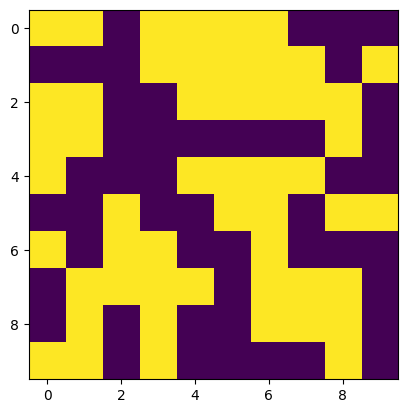

In [ ]:
plt.imshow(criarMatrizValoresAleatorios(10, 0.5))

### **Calculo Magnetização**
---


O cálculo da magnetização será feita da seguinte forma:


In [ ]:
@jit(nopython = True)
def calcularMagnetizacao(
    estadoSistema: list[int]
  ) -> int:
  return np.sum(estadoSistema)

### **Calculo de Energia**
---


O cálculo da energia é feita da seguinte forma:

In [ ]:
@jit(nopython = True)
def calcularEnergiaTotal(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]]
  ) -> float:

  quantidadeSpins: int = len(estadoSistema)
  energia: float = 0

  for i in range(quantidadeSpins):
    vizinhoDireito: int = tabelaVizinhos[i, 0]
    VizinhoSuperior: int = tabelaVizinhos[i, 1]
    somaSpinsSuperiorEDireito: float = (
        estadoSistema[vizinhoDireito] + estadoSistema[VizinhoSuperior]
    )
    energia -= estadoSistema[i] * somaSpinsSuperiorEDireito

  return energia

### **Calculo da Variação de Energia**
---


O cáculo da variação de energia pode ser feito da forma abaixo. Contudo, ela não será utilizada no final, pois os possíveis resultados são -8, -4, 0, 4, 8. Assim, podemos pré-computar os resultados e utilizaremos esses valores para executar o algoritmo mais rápido.

In [ ]:
def calcularEnergiaSpin(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    indiceSpinAlvo: int = 0
  ) -> int:

  spin: int = estadoSistema[indiceSpinAlvo]
  spinsVizinhos: list[int] = (
    [estadoSistema[indiceVizinho] for indiceVizinho in tabelaVizinhos[indiceSpinAlvo]]
  )

  return 2 * spin * np.sum(spinsVizinhos)

In [ ]:
def calcularEnergiaSpinFlipado(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    indiceSpinAlvo: int = 0
  ) -> int:

  spin: int = estadoSistema[indiceSpinAlvo]
  spinsVizinhos: list[int] = (
    [estadoSistema[indiceVizinho] for indiceVizinho in tabelaVizinhos[indiceSpinAlvo]]
  )

  return -2 * -spin * np.sum(spinsVizinhos)

### **Algoritmo Metrópolis**
---



A seguir temos a implementação do Algoritmo de metrópolis, que depois utilizaremos o modelo de Ising.

**Observação:** Beta = 1 / temperatura

#### **Implementação Otimizada - Algoritmo Metropolis**
---


In [ ]:
@jit(nopython = True)
def criarTabelaExponenciais(beta: float) -> list[float]:
    tabelaExponenciais = np.zeros(5, dtype = np.float32)

    tabelaExponenciais[0] = np.exp(8.0 * beta)
    tabelaExponenciais[1] = np.exp(4.0 * beta)
    tabelaExponenciais[2] = 1.0
    tabelaExponenciais[3] = np.exp(-4.0 * beta)
    tabelaExponenciais[4] = np.exp(-8.0 * beta)

    return tabelaExponenciais

In [ ]:
@jit(nopython = True)
def calcularIndiceExponencial(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    spinAlvo: int
) -> int:

  somaVizinhos = (
    estadoSistema[tabelaVizinhos[spinAlvo][0]] +
    estadoSistema[tabelaVizinhos[spinAlvo][1]] +
    estadoSistema[tabelaVizinhos[spinAlvo][2]] +
    estadoSistema[tabelaVizinhos[spinAlvo][3]]
  )
  resultado = int(
      estadoSistema[spinAlvo] * somaVizinhos * 0.5 + 2
  )

  return resultado

In [ ]:
@jit(nopython = True)
def calcularSomaVizinhos(
    estadoSistema: list[int],
    listaVizinhos: list[list[int]],
    spinAlvo: int
  ) -> int:

  somaVizinhos = (
    estadoSistema[listaVizinhos[spinAlvo, 0]] +
    estadoSistema[listaVizinhos[spinAlvo, 1]] +
    estadoSistema[listaVizinhos[spinAlvo, 2]] +
    estadoSistema[listaVizinhos[spinAlvo, 3]]
  )

  return somaVizinhos

In [ ]:
@jit(nopython = True)
def calcularIndiceExponencial(
    estadoSistema: list[int],
    somaVizinhos: int,
    spinAlvo: int
  ) -> int:

  return int(
      estadoSistema[spinAlvo] * somaVizinhos * 0.5 + 2
  )

In [ ]:
@jit(nopython = True)
def executarAlgoritmoMetropolis(
    quantidadeSpins: int,
    estadoSistema: list[int],
    listaVizinhos: list[list[int]],
    tabelaExponenciais: list[float],
    energiaSistema: float,
    magnetizacaoSistema: float
  ) -> tuple[float, float]:

  for j in range(quantidadeSpins):
    spinAlvo: int = np.random.randint(quantidadeSpins)

    somaVizinhos: int = calcularSomaVizinhos(
        estadoSistema,
        listaVizinhos,
        spinAlvo
    )
    indiceExponencial: int = calcularIndiceExponencial(
        estadoSistema,
        somaVizinhos,
        spinAlvo
    )

    # Otimização: resultado: float = np.exp(-beta * variacaoEnergia)
    resultado: float = tabelaExponenciais[indiceExponencial]
    valorAleatorio: float = np.random.rand()

    if(valorAleatorio <= resultado):
      energiaSistema += 2 * estadoSistema[spinAlvo] * somaVizinhos
      magnetizacaoSistema += -2 * estadoSistema[spinAlvo]
      estadoSistema[spinAlvo] *= -1

  return (energiaSistema, magnetizacaoSistema)

In [ ]:
@jit(nopython = True)
def simularMetropolisPorModeloIsing(
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassos: int
  ) -> tuple[list[float], list[float]]:

  beta: float = 1 / temperatura
  tabelaExponenciais: list[float] = criarTabelaExponenciais(beta)
  estadoSistema: list[int] = criarArrayAleatorio(quantidadeSpins)
  listaVizinhos: list[list[int]] = criarTabelaVizinhos(quantidadeSpins)

  energiasRegistradas: list[float] = np.zeros(quantidadePassos + 1)
  energiaSistema: float = calcularEnergiaTotal(estadoSistema, listaVizinhos)
  energiasRegistradas[0] = energiaSistema

  magnetizacaosRegistradas: list[float] = np.zeros(quantidadePassos + 1)
  magnetizacaoSistema: float = calcularMagnetizacao(estadoSistema)
  magnetizacaosRegistradas[0] = magnetizacaoSistema

  for i in range(1, quantidadePassos + 1):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energiasRegistradas[i] = energiaSistema
    magnetizacaosRegistradas[i] = magnetizacaoSistema

  return (energiasRegistradas, magnetizacaosRegistradas)

In [ ]:
def plotSimulacaoMetropolis(
    energiasRegistradas: list[float],
    magnetizacaosRegistradas: list[float]
) -> None:

  fig, ax = plt.subplots(1, 2, figsize = (15, 5))

  ax[0].plot(energiasRegistradas)
  ax[0].set_title("Evolução temporal energia total")
  ax[0].set_xlabel("Quantidade de passos")
  ax[0].set_ylabel("Energia")

  ax[1].plot(magnetizacaosRegistradas)
  ax[1].set_title("Evolução temporal magnetização total")
  ax[1].set_xlabel("Quantidade de passos")
  ax[1].set_ylabel("Magnetização")
  plt.show()

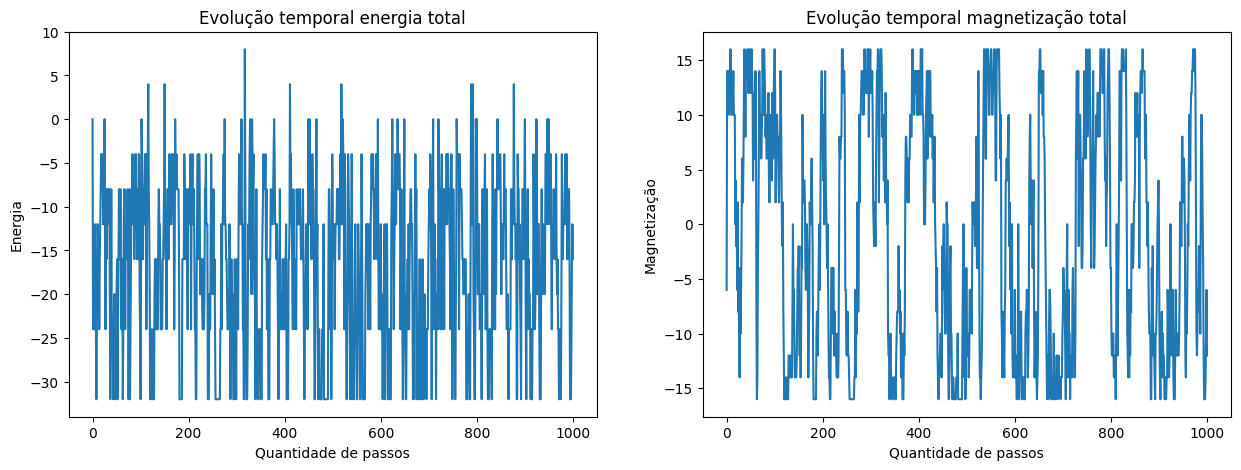

In [ ]:
(energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
    quantidadeSpins = 16,
    temperatura = 3,
    quantidadePassos = 1000
)

plotSimulacaoMetropolis(energiasRegistradas, magnetizacaosRegistradas)

### **Exploração com Simulações e Análise de Resultados**
---

#### **Agrupando diversas simulações de mesmo tipo**
---

Abaixo, temos o gráfico de magnetização e energia ao realizar 7 simulações com parâmetros diferentes e para cada uma realizamos 20 testes:

##### **Resultado Energias**
---


In [1]:
def plotEnergiaVariasSimulacoesComParametrosIguais(
    quantidadeSimulacoes: int,
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:
  quantidadeTiposSimulacoes = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure1, axis1 = plt.subplots(quantidadeTiposSimulacoes, 3, figsize = (9, 5))

  for i in range(quantidadeTiposSimulacoes):
    for j in range(quantidadeSimulacoes):
      (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
          quantidadeSpins = quantidadeSpinsSimulacoes[i],
          temperatura = temperaturasSimulacoes[i],
          quantidadePassos = quantidadePassosSimulacoes
      )

      axis1[i].plot(energiasRegistradas)
      axis1[i].set_title(f"Simulação {i}")
      axis1[i].set_xlabel("Quantidade de passos")
      axis1[i].set_ylabel("Energia")

  figure1.subplots_adjust(top = 6)
  plt.show()

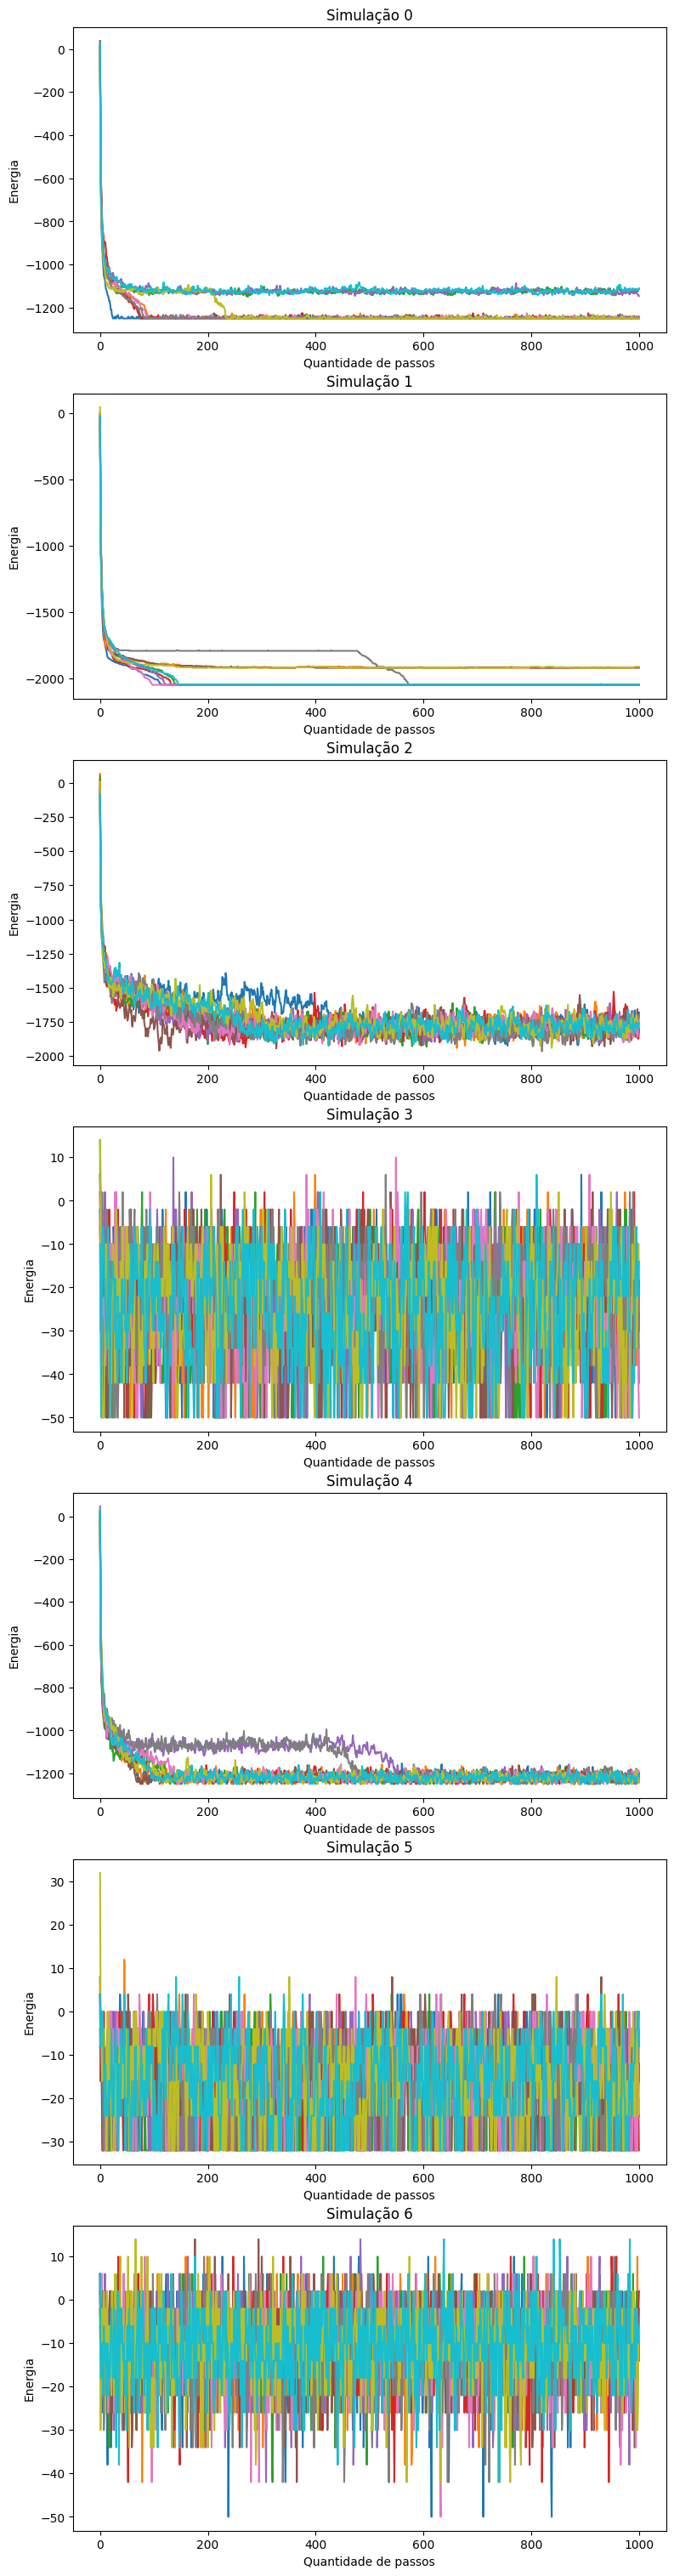

In [ ]:
plotEnergiaVariasSimulacoesComParametrosIguais(
  quantidadeSimulacoes = 10,
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

##### **Resultado magnetizações**
---


In [ ]:
def plotMagnetizacaoVariasSimulacoesComParametrosIguais(
    quantidadeSimulacoes: int,
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:
  quantidadeTiposSimulacoes = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure2, axis2 = plt.subplots(quantidadeTiposSimulacoes, 1, figsize = (15, 15))

  for i in range(quantidadeTiposSimulacoes):
    for j in range(quantidadeSimulacoes):
      (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
          quantidadeSpins = quantidadeSpinsSimulacoes[i],
          temperatura = temperaturasSimulacoes[i],
          quantidadePassos = quantidadePassosSimulacoes
      )

      axis2[i].plot(magnetizacaosRegistradas)
      axis2[i].set_title(f"Simulação {i}")
      axis2[i].set_xlabel("Quantidade de passos")
      axis2[i].set_ylabel("Magnetização")

  figure2.subplots_adjust(top = 3)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

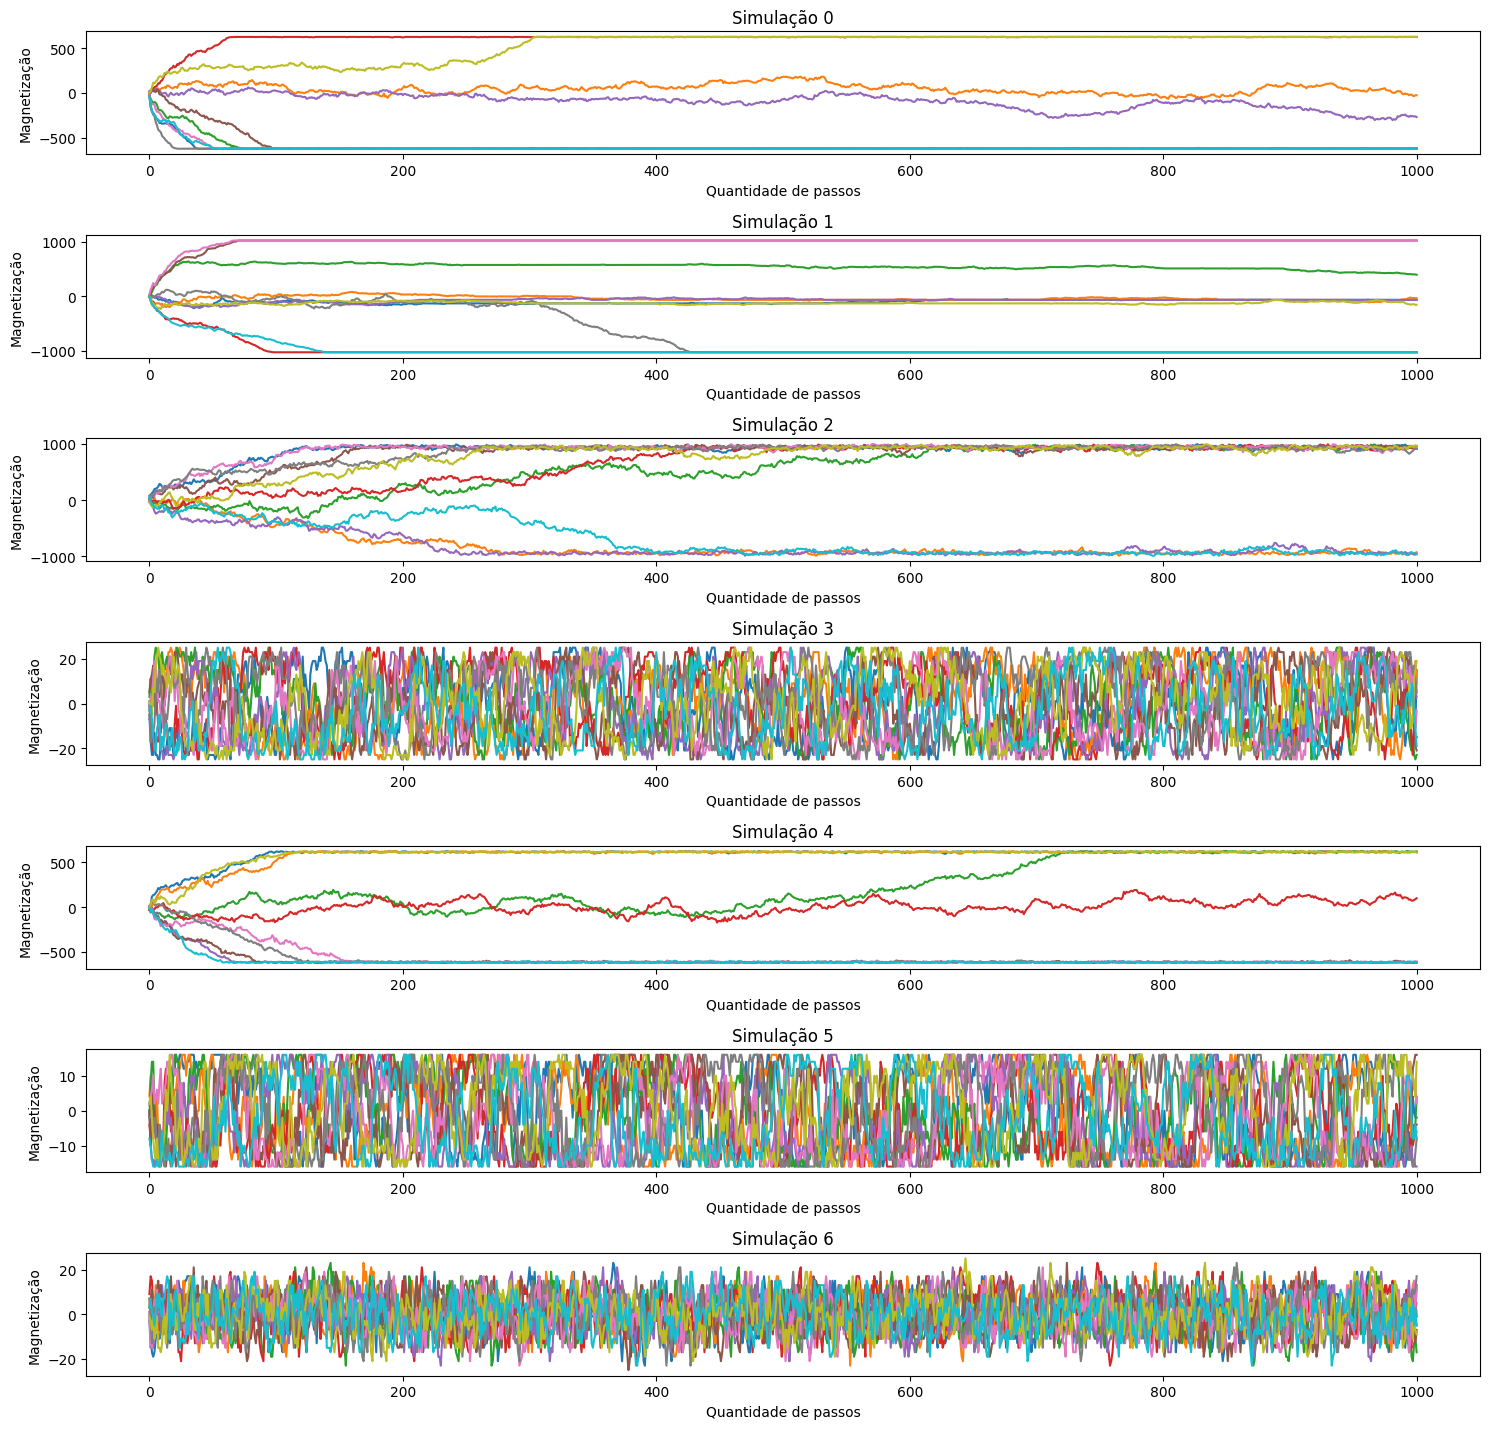

In [ ]:
plotMagnetizacaoVariasSimulacoesComParametrosIguais(
  quantidadeSimulacoes = 10,
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

#### **Agrupando diferentes simulações**
---

Já neste caso, realizamos 1 teste para cada um dos 7 tipos de simulações diferentes (com diferentes conjuntos de parâmetros) e as agrupamos em um mesmo gráfico:

In [ ]:
def realizarSimulacoesSimultaneas(
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:

  quantidadeSimulacoes: int = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure1, axis1 = plt.subplots(1, 1)
  figure2, axis2 = plt.subplots(1, 1)
  labels = []

  for i in range(quantidadeSimulacoes):
    (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
        quantidadeSpins = quantidadeSpinsSimulacoes[i],
        temperatura = temperaturasSimulacoes[i],
        quantidadePassos = quantidadePassosSimulacoes
    )

    labels.append(f"Temperatura: {temperaturasSimulacoes[i]}, Rede: {int(np.sqrt(quantidadeSpinsSimulacoes[i]))}x{int(np.sqrt(quantidadeSpinsSimulacoes[i]))}")
    axis1.set_title(f"Energia total - {quantidadeSimulacoes} Simulações")
    axis1.set_xlabel("Quantidade de passos")
    axis1.set_ylabel("Energia")
    axis1.plot(energiasRegistradas)

    axis2.set_title(f"Magnetização total - {quantidadeSimulacoes} Tipos Simulações")
    axis2.set_xlabel("Quantidade de passos")
    axis2.set_ylabel("Magnetização")
    axis2.plot(magnetizacaosRegistradas)

  axis1.legend(labels = labels, loc = 'upper left', bbox_to_anchor = (1, 1))
  axis2.legend(labels = labels, loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.show()

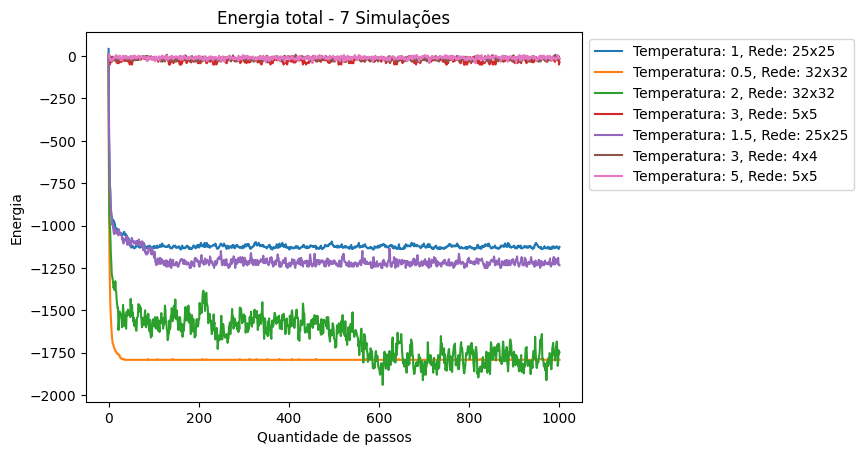

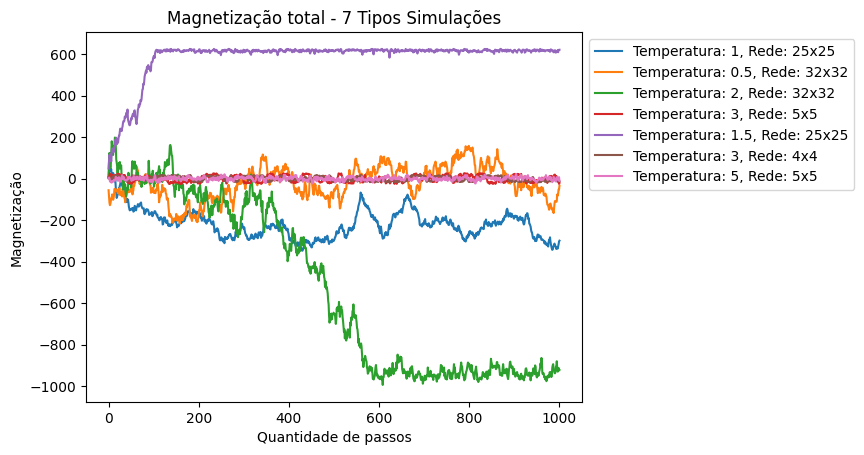

In [ ]:
realizarSimulacoesSimultaneas(
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

#### **Análise**
---

Como estudado em sala, o que observamos aqui é a partida de um ponto aleatório na curva de magnetização até encontrar um ponto de vale. Nós avançamos a ele à medida que a energia reduz, como é possível notar nos outros gráficos. Quando chegamos nesse ponto, nós acabamos encontrando uma oscilação sobre um valor médio, que pode ser uma termalização, caso esteja convergindo consistentemente para ele.

A quantidade de passos necessários para chegar a um estado de termalização é, fazendo um chute alto, é de 600 a 800 passos. Contudo, diversas simulações não chegaram a um ponto de termalização nem com 1000 passos, como as simulações 0, 1, 4. Por outro lado, outras já conseguiram chegar a termalização ou iniciar nela, como nos casos 2, 3, 5 e 6.

Por meio dessa análise qualitativa utilizando os gráficos, verificamos que o número de passos para atingir a termalização, realmente, varia segundo o tamanho do sistema e a temperatura. Segundo nossos testes, acreditamos que quanto maior a temperatura (energia) mais fácil será atingir o estado de termalização, o que também se aplica a quanto menor for o tamanho da rede de spins.

### **Simular Processo de Termalização**
---


Uma vez que já somos capazes de simular com o algoritmo de Metropolis. Podemos criar um algoritmo para descartar valores e chegar a um ponto de termalização, retornando apenas ele.

Segundo a análise realizada e os resultados obtidos, é possível notar que os valores de 600 e 800 são pontos onde os valores costumam começar a oscilar sobre uma média, como no caso da Simulação 2 feita anteriormente.

In [ ]:
def simularTermalizacao(
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int
  ) -> list[float, float, float, float]:

  energiasDescartadas: list[float] = np.zeros(quantidadePassosDescartados)
  magnetizacoesDescartadas: list[float] = np.zeros(quantidadePassosDescartados)

  beta: float = 1 / temperatura
  tabelaExponenciais = criarTabelaExponenciais(beta)
  estadoSistema: list[int] = criarArrayAleatorio(quantidadeSpins)
  listaVizinhos: list[list[int]] = criarTabelaVizinhos(quantidadeSpins)

  energiaSistema: float = calcularEnergiaTotal(estadoSistema, listaVizinhos)
  magnetizacaoSistema: float = calcularMagnetizacao(estadoSistema)

  for i in range(quantidadePassosDescartados):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energiasDescartadas[i] = energiaSistema
    magnetizacoesDescartadas[i] = magnetizacaoSistema

  energias: list[float] = np.zeros(quantidadePassosUteis)
  magnetizacoes: list[float] = np.zeros(quantidadePassosUteis)

  for i in range(quantidadePassosUteis):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energias[i] = energiaSistema
    magnetizacoes[i] = magnetizacaoSistema

  return (
    energias, magnetizacoes, energiasDescartadas, magnetizacoesDescartadas
  )

In [ ]:
(energiasRegistradas, magnetizacaosRegistradas,
 energiasDescartadas, magnetizacoesDescartadas) = simularTermalizacao(
    quantidadeSpins = 1024,
    temperatura = 2,
    quantidadePassosDescartados = 600,
    quantidadePassosUteis = 400
)

Utilizando os mesmos parâmetros da simulação 2, iremos gerar um gráfico apenas com os valores partindo do ponto de termalização e ignorando os passos anteriores. Ou seja, iremos partir depois dos 600 primeiros passos dentre o total de 1000.

Resultados Relevantes


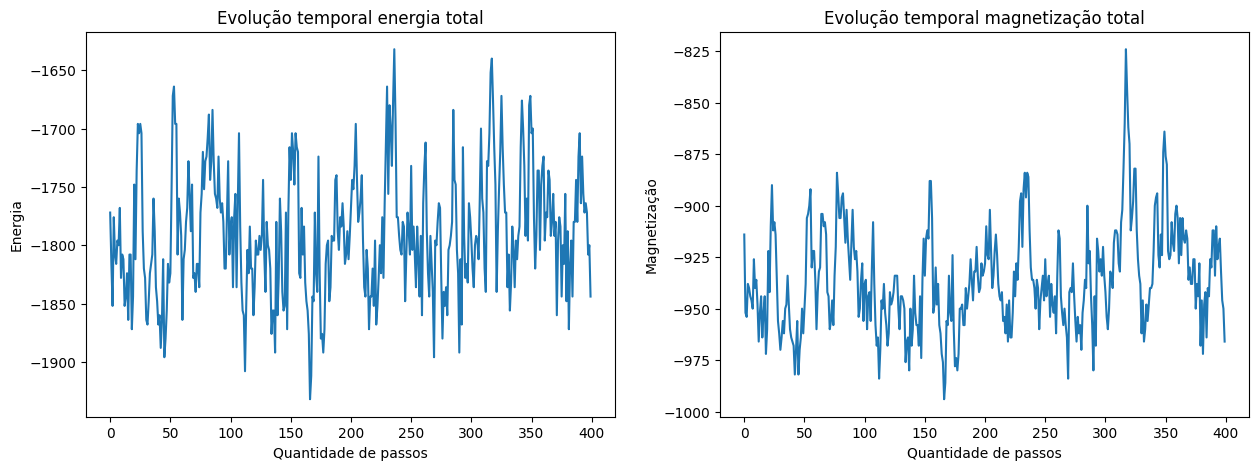

In [ ]:
print("Resultados Relevantes")
plotSimulacaoMetropolis(energiasRegistradas, magnetizacaosRegistradas)

É possível notar nos gráficos anteriores que eles oscilam entre valores médios específicos.

Agora, podemos testar os valores anteriores a eles. Iremos criar um gráfico para os valores de energia e magnetização total que foram descartados antes da termalização:

Resultados Descartados


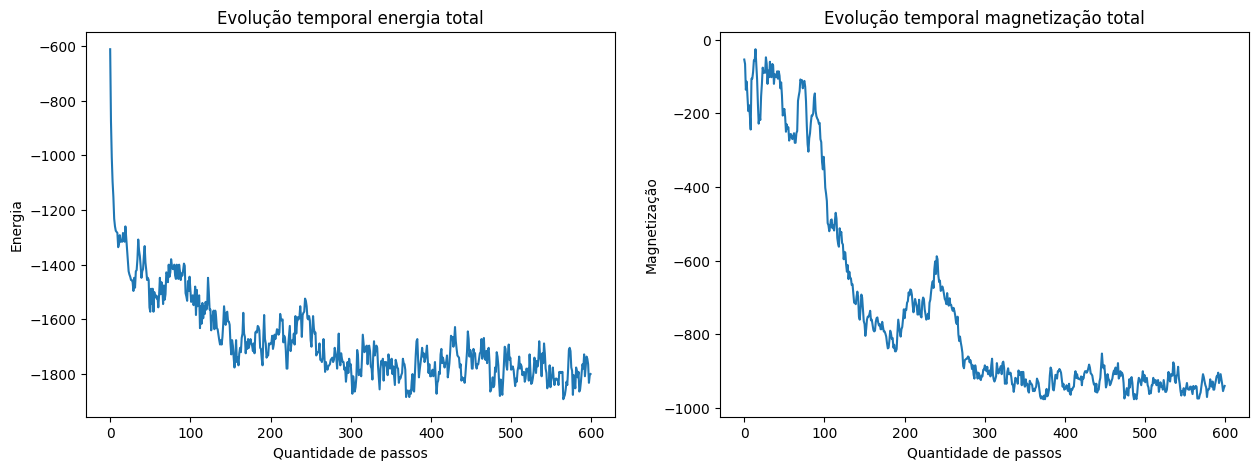

In [ ]:
print("Resultados Descartados")
plotSimulacaoMetropolis(energiasDescartadas, magnetizacoesDescartadas)

## **Parte 2: Erros Estatísticos**
---


In [ ]:
TAMANHO_TERMALIZADOS: list[int] = [1024, 25, 100, 16]
TEMPERATURAS_TERMALIZADAS: list[float] = [2, 3, 1.5, 3]

In [ ]:
def calcularCalorEspecifico(
    energia: list[float],
    temperatura: float,
    quantidadeSpins: int
  ) -> float:

  beta: float = 1 / temperatura
  mediaEnergia: float = stat.mean(energia)
  mediaEnergiaQuadrado: float = stat.mean(np.square(energia))
  calorEspecifico: float = (
    (beta**2) / quantidadeSpins * (mediaEnergiaQuadrado - (mediaEnergia**2))
  )

  return calorEspecifico

In [ ]:
def calcularSusceptibilidadeMagnetizacao(
    magnetizacao: list[float],
    temperatura: float,
    quantidadeSpins: int
  ) -> float:

  beta: float = 1 / temperatura
  mediaMagnetizacao: float = stat.mean(np.abs(magnetizacao))
  mediaMagnetizacaoQuadrado: float = stat.mean(np.square(magnetizacao))
  magnetizacao: float = (
    beta / quantidadeSpins * (mediaMagnetizacaoQuadrado - (mediaMagnetizacao**2))
  )

  return magnetizacao

In [ ]:
def calcularErroEstatistico(valores: list[float]) -> float:
  tamanho: int = len(valores)
  media: float = stat.mean(valores)
  diferencaQuadrada: float = (valores - media) ** 2
  erroEstatistico: float = np.sqrt(
      np.sum(diferencaQuadrada) / (tamanho * (tamanho - 1))
  )

  return erroEstatistico

In [ ]:
def calcularEstatisticasModeloIsing(
    quantidadeBlocos: int,
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int
) -> list[float, float]:
  (energiasRegistradas, magnetizacoesRegistradas,
   energiasDescartadas, magnetizacoesDescartadas) = simularTermalizacao(
      quantidadeSpins,
      temperatura,
      quantidadePassosDescartados,
      quantidadePassosUteis
  )

  energiasPorBlocos = np.array_split(
    energiasRegistradas,
    quantidadeBlocos
  )

  magnetizacaoPorBlocos = np.array_split(
    magnetizacoesRegistradas,
    quantidadeBlocos
  )

  mediasEnergiasPorBlocos: list[float] = np.zeros(quantidadeBlocos)
  mediasMagnetizacaoPorBlocos: list[float] = np.zeros(quantidadeBlocos)
  mediasMagnetizacaoAbsolutaPorBloco: list[float] = np.zeros(quantidadeBlocos)
  energiaPorSpin: list[float] = np.zeros(quantidadeBlocos)
  magnetizacaoPorSpin: list[float] = np.zeros(quantidadeBlocos)
  caloresEspecificos: list[float] = np.zeros(quantidadeBlocos)
  susceptibilidadesMagnetizacao: list[float] = np.zeros(quantidadeBlocos)

  for i in range(quantidadeBlocos):
    mediasEnergiasPorBlocos[i] = np.mean(energiasPorBlocos[i])
    mediasMagnetizacaoPorBlocos[i] = np.mean(magnetizacaoPorBlocos[i])
    mediasMagnetizacaoAbsolutaPorBloco[i] = np.mean(
      np.abs(magnetizacaoPorBlocos[i])
    )
    energiaPorSpin[i] = mediasEnergiasPorBlocos[i] / quantidadeSpins
    magnetizacaoPorSpin[i] = mediasMagnetizacaoPorBlocos[i] / quantidadeSpins
    caloresEspecificos[i] = calcularCalorEspecifico(
      energiasPorBlocos[i],
      temperatura,
      quantidadeSpins
    )
    susceptibilidadesMagnetizacao[i] = calcularSusceptibilidadeMagnetizacao(
      magnetizacaoPorBlocos[i],
      temperatura,
      quantidadeSpins
    )

  calorEspecificoFinal: float = np.mean(caloresEspecificos)
  erroEstatisticoCalorEspecifico = calcularErroEstatistico(caloresEspecificos)

  susceptibilidadeFinal: float = np.mean(susceptibilidadesMagnetizacao)
  erroEstatisticoSusceptibilidade = calcularErroEstatistico(
    susceptibilidadesMagnetizacao
  )

  energiaPorSpinFinal: float = np.mean(energiaPorSpin)
  erroEstatisticoEnergiaPorSpin = calcularErroEstatistico(energiaPorSpin)

  magnetizacaoPorSpinFinal: float = np.mean(magnetizacaoPorSpin)
  erroEstatisticoMagnetizacaoPorSpin = calcularErroEstatistico(
    magnetizacaoPorSpin
  )

  energiaFinal: float = np.mean(mediasEnergiasPorBlocos)
  erroEstatisticoEnergiaFinal = calcularErroEstatistico(mediasEnergiasPorBlocos)

  magnetizacaoFinal: float = np.mean(mediasMagnetizacaoPorBlocos)
  erroEstatisticoMagnetizacaoFinal = calcularErroEstatistico(
    mediasMagnetizacaoPorBlocos
  )

  resultados = {
      "mediasEnergiasPorBlocos": mediasEnergiasPorBlocos,
      "mediasMagnetizacaoPorBlocos": mediasMagnetizacaoPorBlocos,
      "mediasMagnetizacaoAbsolutaPorBloco": mediasMagnetizacaoAbsolutaPorBloco,
      "energiaPorSpin": energiaPorSpin,
      "magnetizacaoPorSpin": magnetizacaoPorSpin,
      "caloresEspecificos": caloresEspecificos,
      "susceptibilidadesMagnetizacao": susceptibilidadesMagnetizacao,
      "calorEspecificoFinal": calorEspecificoFinal,
      "susceptibilidadeFinal": susceptibilidadeFinal,
      "energiaPorSpinFinal": energiaPorSpinFinal,
      "magnetizacaoPorSpinFinal": magnetizacaoPorSpinFinal,
      "energiaFinal": energiaFinal,
      "magnetizacaoFinal": magnetizacaoFinal,
      "erroEstatisticoCalorEspecifico": erroEstatisticoCalorEspecifico,
      "erroEstatisticoSusceptibilidade": erroEstatisticoSusceptibilidade,
      "erroEstatisticoEnergiaPorSpin": erroEstatisticoEnergiaPorSpin,
      "erroEstatisticoMagnetizacaoPorSpin": erroEstatisticoMagnetizacaoPorSpin,
      "erroEstatisticoEnergiaFinal": erroEstatisticoEnergiaFinal,
      "erroEstatisticoMagnetizacaoFinal": erroEstatisticoMagnetizacaoFinal,
      "erroMedio": np.mean([
        erroEstatisticoCalorEspecifico,
        erroEstatisticoSusceptibilidade,
        erroEstatisticoEnergiaPorSpin,
        erroEstatisticoMagnetizacaoPorSpin,
        erroEstatisticoEnergiaFinal,
        erroEstatisticoMagnetizacaoFinal
      ])
  }

  return resultados

In [ ]:
calcularEstatisticasModeloIsing(
    quantidadeBlocos = 10,
    quantidadeSpins = TAMANHO_TERMALIZADOS[0],
    temperatura = TEMPERATURAS_TERMALIZADAS[0],
    quantidadePassosDescartados = 600,
    quantidadePassosUteis = 400
)

{'mediasEnergiasPorBlocos': array([-1767.4, -1771.5, -1798.4, -1794.9, -1764.7, -1796.4, -1785.4,
        -1767.3, -1813.6, -1798.1]),
 'mediasMagnetizacaoPorBlocos': array([-917.55, -926.3 , -941.1 , -941.3 , -919.15, -930.75, -935.3 ,
        -921.55, -948.1 , -939.9 ]),
 'mediasMagnetizacaoAbsolutaPorBloco': array([917.55, 926.3 , 941.1 , 941.3 , 919.15, 930.75, 935.3 , 921.55,
        948.1 , 939.9 ]),
 'energiaPorSpin': array([-1.72597656, -1.72998047, -1.75625   , -1.75283203, -1.72333984,
        -1.75429688, -1.74355469, -1.72587891, -1.77109375, -1.75595703]),
 'magnetizacaoPorSpin': array([-0.89604492, -0.90458984, -0.91904297, -0.91923828, -0.89760742,
        -0.90893555, -0.91337891, -0.89995117, -0.92587891, -0.91787109]),
 'caloresEspecificos': array([0.28584961, 0.64691162, 0.35347656, 0.88671631, 1.13884521,
        0.68433594, 0.54209961, 0.39060303, 0.64429688, 0.62577881]),
 'susceptibilidadesMagnetizacao': array([0.16869995, 0.25259277, 0.11903809, 0.30581543, 0.66

### **Comportamentos variando apenas a temperatura**
---


In [ ]:
TEMPERATURA_MINIMA: int = -35
TEMPERATURA_MAXIMA: int = 35

#### **Variação do  erro em função da temperatura**
---


In [ ]:
def simularVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float,
    quantidadeBlocos: int,
    quantidadeSpins: int,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int,
    atributo,
    atributoErroEstatistico
  ) -> None:

  energiaPorSpinFinal: list[float] = []
  temperaturas: list[float] = []
  erroEstatistico: list[float] = []

  figResultado, axResultado = plt.subplots(1, 2, figsize = (10, 5))

  for temperatura in range(temperaturaMinima, temperaturaMaxima):
    if temperatura == 0:
      continue

    resultados = calcularEstatisticasModeloIsing(
        quantidadeBlocos = quantidadeBlocos,
        quantidadeSpins = quantidadeSpins,
        temperatura = temperatura,
        quantidadePassosDescartados = quantidadePassosDescartados,
        quantidadePassosUteis = quantidadePassosUteis
    )

    energiaPorSpinFinal.append(resultados[atributo])
    temperaturas.append(temperatura)
    erroEstatistico.append(resultados[atributoErroEstatistico])

  axResultado[0].set_xlabel("Temperatura")
  axResultado[0].set_ylabel(atributo)
  axResultado[0].set_title(atributo)
  axResultado[0].plot(temperaturas, energiaPorSpinFinal)

  axResultado[1].set_xlabel("Temperatura")
  axResultado[1].set_ylabel(atributoErroEstatistico)
  axResultado[1].set_title(atributoErroEstatistico)
  axResultado[1].plot(temperaturas, erroEstatistico)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

#### **Energia por spin em função da temperatura**
---


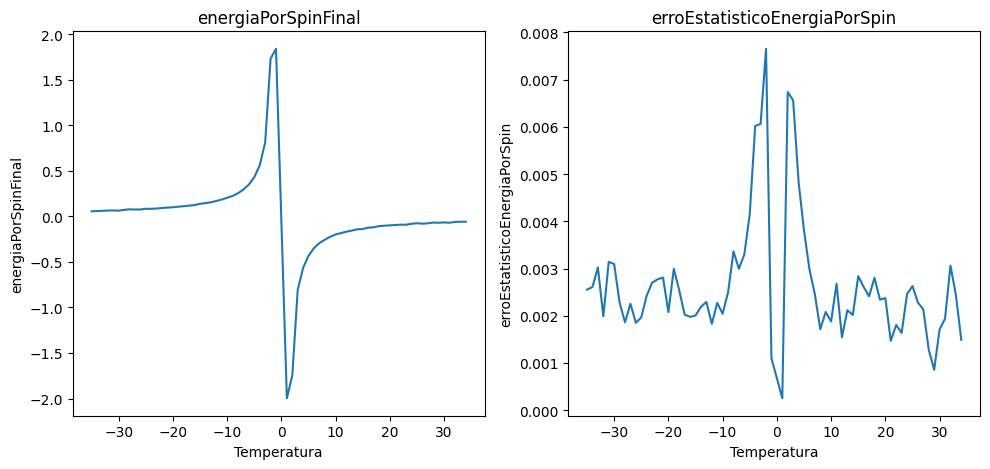

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "energiaPorSpinFinal",
  atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Magnetização em função da temperatura**
---


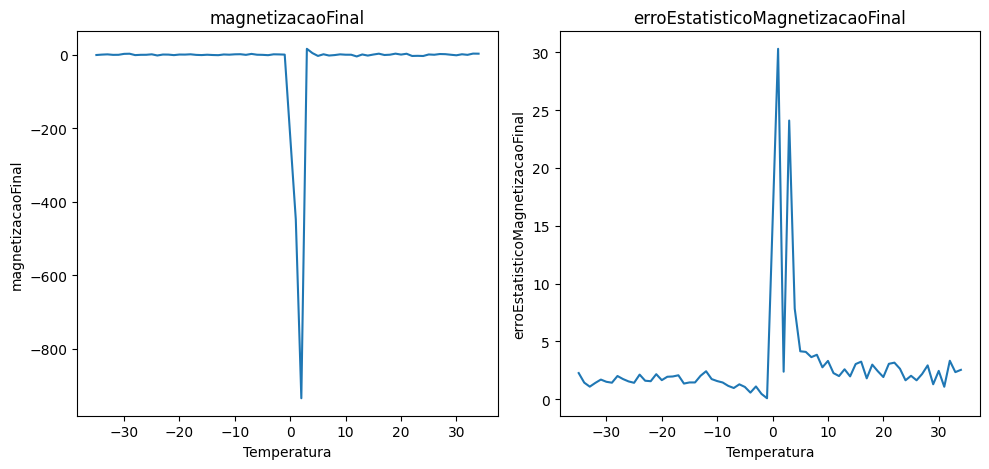

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "magnetizacaoFinal",
  atributoErroEstatistico = "erroEstatisticoMagnetizacaoFinal"
)

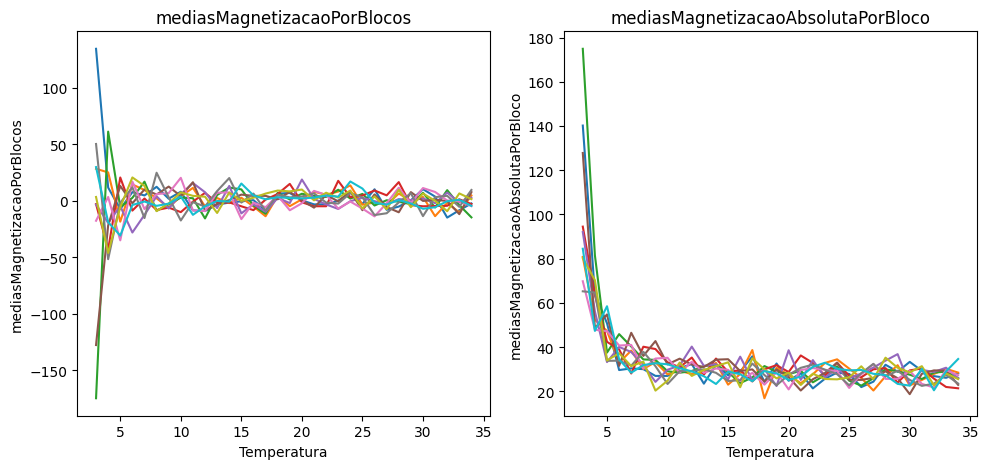

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = 3,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "mediasMagnetizacaoPorBlocos",
  atributoErroEstatistico = "mediasMagnetizacaoAbsolutaPorBloco"
)

#### **Calor específico em função da temperatura**
---


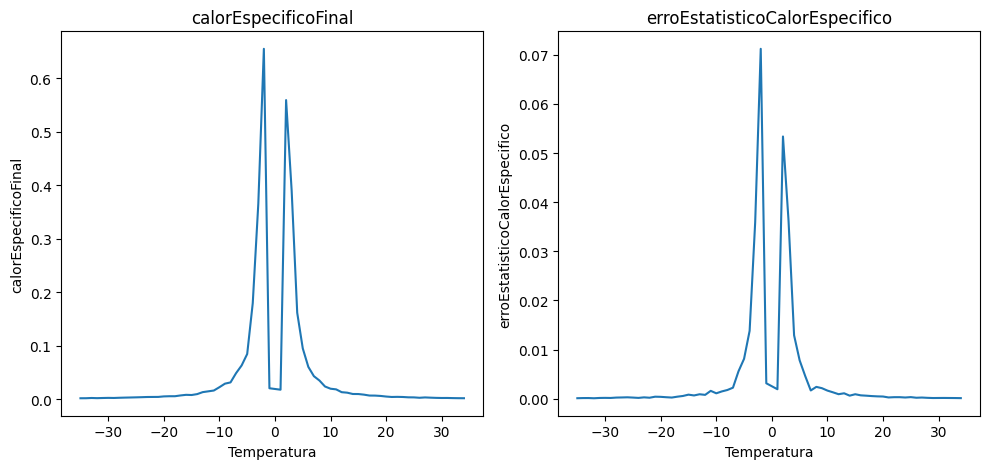

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "calorEspecificoFinal",
  atributoErroEstatistico = "erroEstatisticoCalorEspecifico"
)

#### **Suceptibilidade em função da temperatura**
---


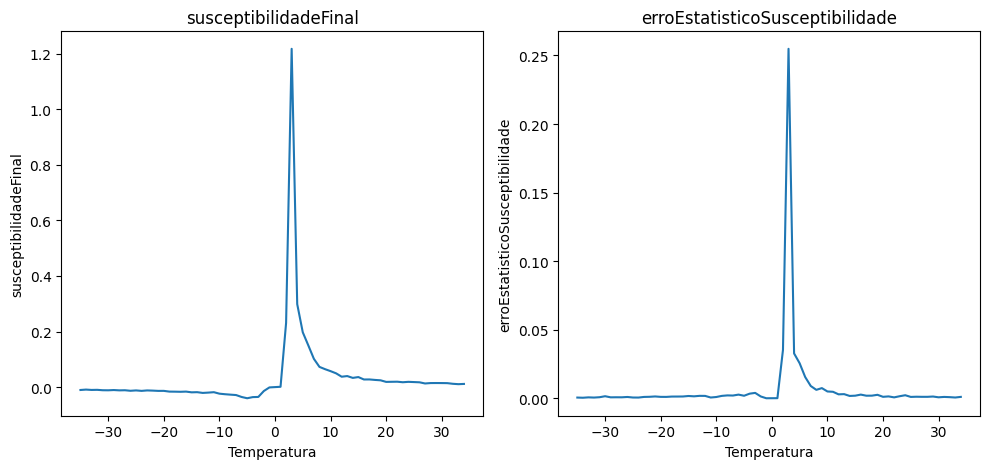

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "susceptibilidadeFinal",
  atributoErroEstatistico = "erroEstatisticoSusceptibilidade"
)

### **Comportamentos variando o tamanho**
---


In [ ]:
def plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float,
    atributo: str,
    atributoErroEstatistico: str
  ) -> None:

  def simularVariacaoAtributoEmFuncaoTemperaturaGruped(
      temperaturaMinima: float,
      temperaturaMaxima: float,
      quantidadeBlocos: int,
      quantidadeSpins: int,
      quantidadePassosDescartados: int,
      quantidadePassosUteis: int,
      atributo: str,
      atributoErroEstatistico: str
    ) -> None:

    energiaPorSpinFinal: list[float] = []
    temperaturas: list[float] = []
    erros: list[float] = []

    for temperatura in range(temperaturaMinima, temperaturaMaxima):
      if temperatura == 0:
        continue

      resultados = calcularEstatisticasModeloIsing(
          quantidadeBlocos = quantidadeBlocos,
          quantidadeSpins = quantidadeSpins,
          temperatura = temperatura,
          quantidadePassosDescartados = quantidadePassosDescartados,
          quantidadePassosUteis = quantidadePassosUteis
      )

      energiaPorSpinFinal.append(resultados[atributo])
      temperaturas.append(temperatura)
      erros.append(resultados[atributoErroEstatistico])

    return {
      "temperaturas": temperaturas,
      "energiaPorSpinFinal": energiaPorSpinFinal,
      "erros": erros,
      "quantidadeSpins": quantidadeSpins
    }

  resultados = []
  figResultado, axResultado = plt.subplots(1, 2, figsize = (10, 5))

  for i in range(len(TAMANHO_TERMALIZADOS)):
    resultado = simularVariacaoAtributoEmFuncaoTemperaturaGruped(
        temperaturaMinima = temperaturaMinima,
        temperaturaMaxima = temperaturaMaxima,
        quantidadeBlocos = 10,
        quantidadeSpins = TAMANHO_TERMALIZADOS[i],
        quantidadePassosDescartados = 600,
        quantidadePassosUteis = 400,
        atributo = atributo,
        atributoErroEstatistico = atributoErroEstatistico
    )
    resultados.append(resultado)

  for i in range(len(resultados)):
    axResultado[0].plot(
        resultados[i]["temperaturas"],
        resultados[i]["energiaPorSpinFinal"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )
    axResultado[1].plot(
        resultados[i]["temperaturas"],
        resultados[i]["erros"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )

  axResultado[0].set_label("Temperatura")
  axResultado[0].set_ylabel(atributo)
  axResultado[0].set_title(atributo)
  axResultado[1].set_label("Temperatura")
  axResultado[1].set_ylabel(atributoErroEstatistico)
  axResultado[1].set_title(atributoErroEstatistico)
  axResultado[1].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

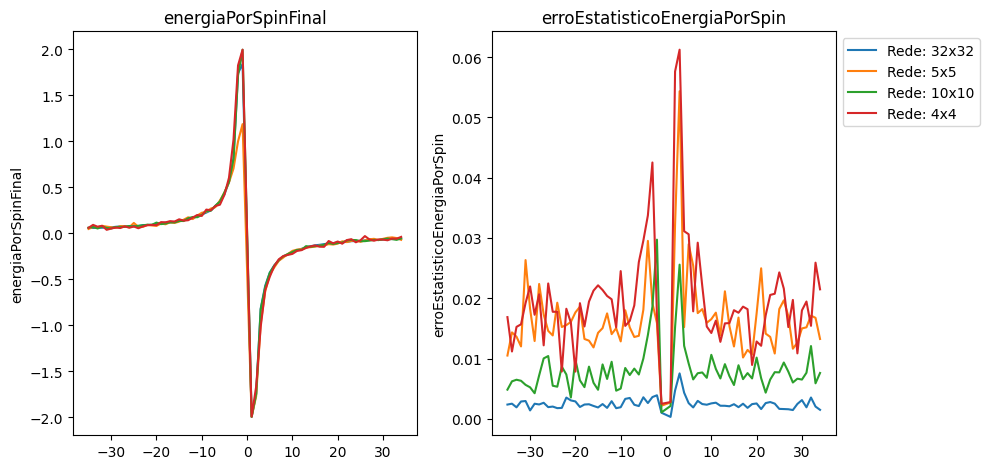

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  atributo = "energiaPorSpinFinal",
  atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Energia por spin em função da temperatura**
---


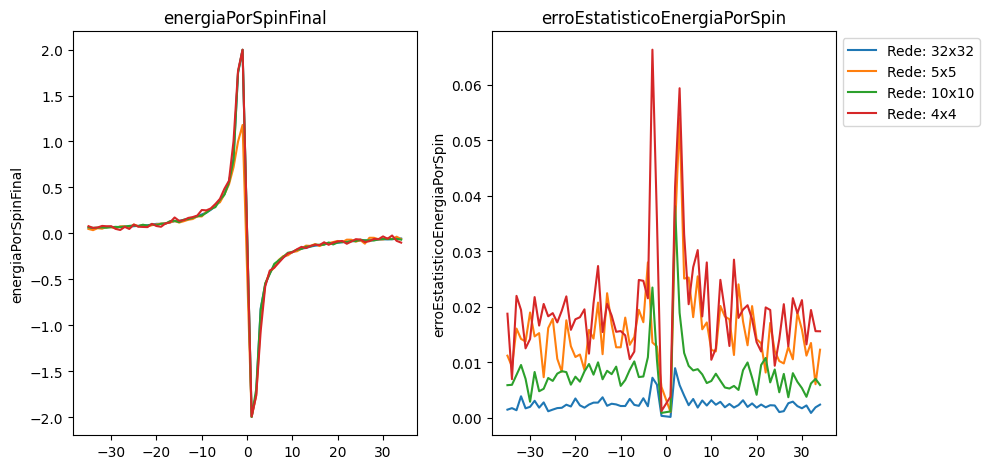

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "energiaPorSpinFinal",
    atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Magnetização em função da temperatura**
---


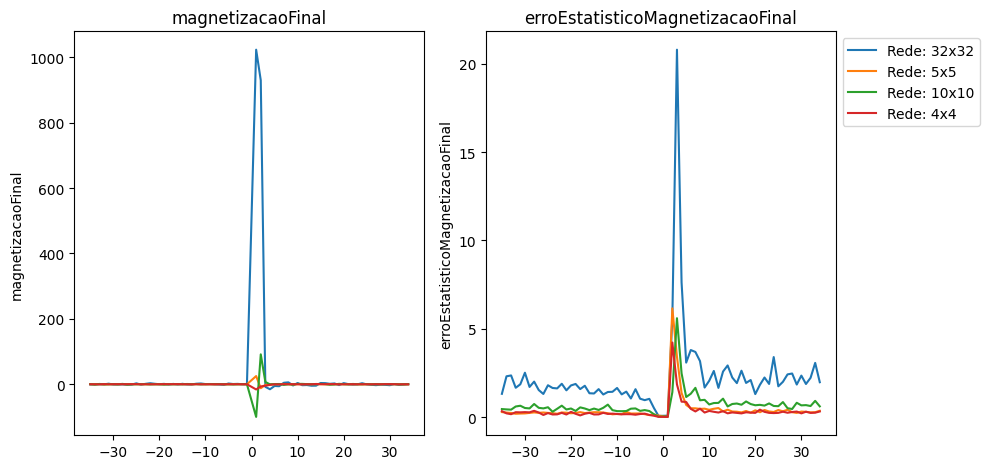

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "magnetizacaoFinal",
    atributoErroEstatistico = "erroEstatisticoMagnetizacaoFinal"
)

#### **Calor específico em função da temperatura**
---


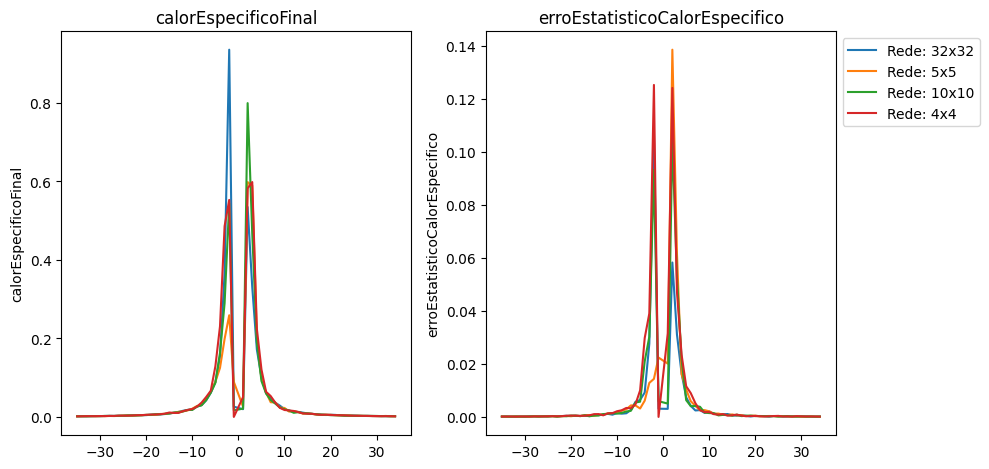

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "calorEspecificoFinal",
    atributoErroEstatistico = "erroEstatisticoCalorEspecifico"
)

#### **Suceptibilidade em função da temperatura**
---


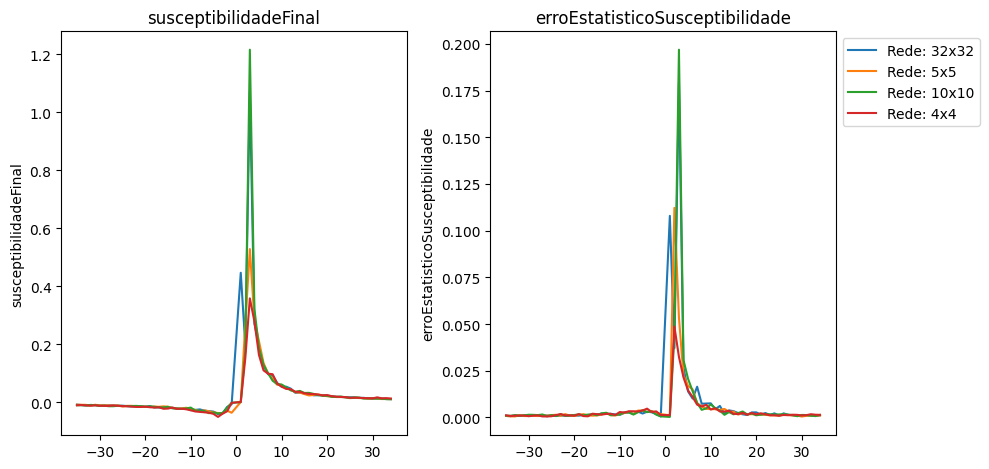

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "susceptibilidadeFinal",
    atributoErroEstatistico = "erroEstatisticoSusceptibilidade"
)

### **Respostas para questões**
---


#### **Questão 1)**
---


* Quais critérios você utilizou para escolher os valores dos parâmetros? Quais os principais fatores que nortearam suas escolhas finais?

 * Nós utilizamos como parâmetros para a temperatura os valores de -35 a 35, o motivo desta escolha foi que ela permitiria um maior foco nos detalhes dos gráficos de variação de temperatura, uma vez que esta já se estabiliza entre -20 e 20.
  
  * Para os parametros N<sub>term</sub> e N<sub>MCS</sub> utilizamos respectivamente os valores 600, equivalendo aos passos descartádos, e 400, equivalendo aos passos úteis. Escolhemos estes valores, pois tendo em vista as explorações realizadas na primeira metade do trabalho foi apenas a partir do passo 600 que a simulação de número 2 convergiu.

  * Para o tamanho do sistema nos escolhemos os valores de 1024, 25, 100 e 16, pois foram para estas redes de spins que conseguimos resultados que termalizaram na primeira metade da atividade.

#### **Questão 2)**
---


* Ao variar a temperatura, o que acontece com o valor das grandezas Energia por spin, Magnetização por spin, calor específico e susceptibilidade magnética?
* Quais são os limites para baixas e altas temperaturas?
* Há algum pico ou vale?
* O comportamento está em acordo com o que você esperava?

O gráfico de energia por spin apresenta um comportamento interessante, apesar de possuir apenas derivadas positivas é descontínuo no ponto zero, em virtude do beta que não pode ser definido quando há uma divisão por zero em seu cálculo, desta maneira, apesar das derivadas sempre positivas, ele se reduz ao passar do limite de zero pela direita para o limite de zero pela esquerda, respectivamente o pico(2) e o vale(-2) da função. Isso não bateu com as nossas expectativas uma vez que esperávamos que a energia sempre aumentaria quando a temperatura fosse aumentada, fato este que não ocorreu, como indica a posição do próprio vale do gráfico.

No gráfico de magnetização por spin, podemos notar que a magnetização oscila em torno de zero pela maior parte do gráfico, apenas assumindo comportamento diferente ao aproximar-se de zero, começando a assumir valores diferentes do nulo entre -5 e 5 graus celsius, este gráfico também podemos notar, é descontínuo para o valor zero e seu limite pela direita é o vale (-1000) do gráfico, enquanto seu limite pela esquerda é seu pico(1000). Já tendo analisado o comportamento do gráfico de energia por spin, este resultado não é surpreendente, apesar da intensidade do salto na magnetização ao se aproximar muito de zero o ser.

No gráfico do calor específico, temos novamente um comportamento diferente do padrão do resto do gráfico ao nos aproximarmos do zero, embora, neste caso, isso comece a causar alterações no gráfico consideravelmente antes, nas marcas de -15 e 15 aproximadamente. Há neste caso um pico(0.65) para o gráfico, o limite de zero pela direita, entretanto, não há um vale uma vez que quando o gráfico alcança altas temperaturas ou baixas, ele tem valores menores que mais próximo do 0, onde os valores oscilam. O comportamento do gráfico é novamente esperado em partes, uma vez que dada as análises anteriores era de se esperar maiores oscilações próximas de 0 e a descontinuidade neste valor, entretanto a ausência de vale não foi prevista.

Já no gráfico da Susceptibilidade, temos de novo um comportamento diferente próximo ao zero, além disso podemos observar que para temperaturas acima de zero a susceptibilidade apenas diminui e o faz mais rapidamente quando mais próxima de 0 é a temperatura. O pico(0.8) da função é no limite pela esquerda de 0 e seu vale é sutil se comparado às proximidades, mas ainda assim definido e aparece por volta de -3. Este comportamento acabou para fugir em muito do esperado, apenas sendo previsível o fato, a este ponto trivial, de que ele seria descontínuo em 0.

#### **Questão 3)**
---


* Ao variar o tamanho do sistema, como as curvas destas grandezas em função da temperatura se modifica?

* Há algum intervalo de temperaturas no qual as grandezas são independentes do
tamanho do sistema?

* Em regiões onde há variação com o tamanho do sistema, como a
grandeza é modificada quando 𝐿 aumenta?

Quando consideramos energia por spin e como ela se altera com diferentes L encontramos um comportamento peculiar, apesar de a maioria das valorações de L ter um comportamento similar é possível notar uma diferença abrupta na 25, mas mesmo ela se comporta como as outras fora do intervalo de -5 a 5. Neste caso mesmo nesta região não percebemos uma relação entre o crescimento de L e o comportamento da função uma vez que L=16 se comporta como os demais valores e apenas L=25 varia.

Quando consideramos a magnetização vemos uma figura bastante interessante, ela apenas apresenta variação quanto ao valor de L quando consideramos o intervalo entre -3 e 3, entretanto podemos perceber que tanto os picos quanto os vales da região se tornam consideravelmente mais acentuados quanto maior o valor de L, fora deste intervalo entretanto a valoração de L não parece ter influência relevante.

Considerando o calor específico teremos mais dificuldade em encontrar um padrão entre o aumento de L e uma alteração no gráfico. É fato que esta variação se faz presente entre -5 e 5, porém é difícil conectar o comportamento das diferentes curvas aos seus valores de L. Fora deste intervalo a grandeza não parece importar.

Neste último caso, a suceptibilidade, também podemos notar que a variação se faz mais presente entre -5 e 5, porém diferentemente do caso anterior não é difícil relacionar o tamanho de L e o comportamento do gráfico, uma vez que ele é uma relação direta, quando o tamanho de L aumenta aumenta também o quão acentuado é o pico. Fora deste intervalo entretanto não vemos influência relevante do tamanho de L.

#### **Questão 4)**
---


##### **Erro por temperatura**
---

In [ ]:
def plotErroMedioPorTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float
  ) -> None:

  def simularVariacaoErroPorTemperatura(
      temperaturaMinima: float,
      temperaturaMaxima: float,
      quantidadeBlocos: int,
      quantidadeSpins: int,
      quantidadePassosDescartados: int,
      quantidadePassosUteis: int
    ) -> None:

    temperaturas: list[float] = []
    errosMedios: list[float] = []

    for temperatura in range(temperaturaMinima, temperaturaMaxima):
      if temperatura == 0:
        continue

      resultados = calcularEstatisticasModeloIsing(
          quantidadeBlocos = quantidadeBlocos,
          quantidadeSpins = quantidadeSpins,
          temperatura = temperatura,
          quantidadePassosDescartados = quantidadePassosDescartados,
          quantidadePassosUteis = quantidadePassosUteis
      )

      temperaturas.append(temperatura)
      errosMedios.append(resultados["erroMedio"])

    return {
      "temperaturas": temperaturas,
      "erros": errosMedios,
      "quantidadeSpins": quantidadeSpins
    }

  resultados = []
  figResultado, axResultado = plt.subplots(1, 1)

  for i in range(len(TAMANHO_TERMALIZADOS)):
    resultado = simularVariacaoErroPorTemperatura(
        temperaturaMinima = temperaturaMinima,
        temperaturaMaxima = temperaturaMaxima,
        quantidadeBlocos = 10,
        quantidadeSpins = TAMANHO_TERMALIZADOS[i],
        quantidadePassosDescartados = 600,
        quantidadePassosUteis = 400
    )
    resultados.append(resultado)

  for i in range(len(resultados)):
    axResultado.plot(
        resultados[i]["temperaturas"],
        resultados[i]["erros"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )

  axResultado.set_label("Temperatura")
  axResultado.set_ylabel("Erro médio")
  axResultado.set_title("Erro médio x Temperatura")
  axResultado.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.show()

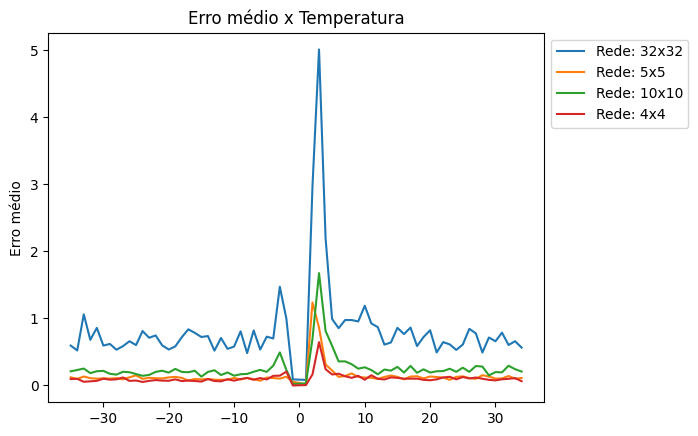

In [ ]:
plotErroMedioPorTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA
)

* Como é o comportamento dos erros estatísticos à medida que a temperatura varia?

* Tem algum valor de temperatura em torno do qual os erros são maiores?

* Você enxerga algum motivo para isso?

* Os erros estatísticos dependem do tamanho do sistema? Como?

Como podemos notar no gráfico o erro tende a ser mais pronunciado entre 0 e aproximadamente 5, mas mesmo fora deste intervalo ainda podemos ver que há oscilações no erro na medida que a temperatura varia. Suponho que como esta área possui maior variação em todas as grandezas, faz sentido que erros estejam mais propensos a surgir nela. Já quando tratamos do tamanho, podemos observar que quando olhamos a grandeza da magnetização podemos ver que um maior valor de L representa um maior erro estatístico, o oposto do comportamento de outras grandezas nas quais um valor de L maior se traduz em um erro menos pronunciado. Desta forma, exceto pelo comportamento da magnetização, a distribuição dos erros estatísticos está ocorrendo como esperada por nós, e estamos intrigadas com o comportamento exibido pela magnetização.

#### **Questão 5)**
---


* Com base no comportamento encontrado, identifique possíveis fases do sistema,
descrevendo as principais características das fases encontradas.

Existem duas fases presentes no sistema, separadas por uma transição próxima do valor nulo. Chamemos a primeira delas de fase negativa, pois ela se localiza em valores de temperatura negativos, e a segunda de fase positiva, pois ela se localiza em valores de temperatura positvos. Na fase negativa temos uma energia por spin consistentemente no zero, entretanto na fase positiva a energia por spin se altera se mantendo consistente em -0,5, no lugar de zero como na fase anterior. É curioso notar que, contra as nossas expectativas, outras grandezas não pareceram variar muito da fase negativa para a positiva. Durante a transição de uma fase para outra no entanto houve variação de todas as grandezas, porém interessantemente, exceto pela energia por spin, as grandezas retornaram aos seus valores que possuiam na fase anterior à transição.

#### **Questão 6)**
---


* Estime, utilizando os dados das suas simulações, a temperatura de transição de fase do sistema no limite termodinâmico, i.e., para o limite em que o tamanho do sistema é infinito.

Como pudemos oberservar nos gráficos a grande mudança acontece próxima de zero, assim sendo quando o tamanho do sistema tender ao infinito a temperatura de transição hávera de tender à zero.